In [13]:
from keras.applications import vgg16
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, TimeDistributed
import numpy as np
from collections import Counter, defaultdict
from keras.preprocessing import image
from PIL import ImageDraw


In [2]:
base_model = vgg16.VGG16(weights='imagenet', include_top=True)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
img = image.load_img('data/cat_dog.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

preds = base_model.predict(x)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

Predicted: [('n02099601', 'golden_retriever', 0.099326335), ('n02100735', 'English_setter', 0.053414322), ('n02106662', 'German_shepherd', 0.048760593)]


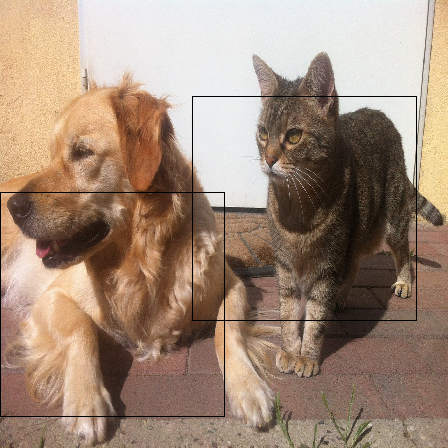

In [32]:
cat_dog = image.load_img('data/cat_dog.jpg', target_size=(448, 448))
draw = ImageDraw.Draw(cat_dog)
draw.rectangle((192, 96, 416, 320), outline=(0, 0, 0))
draw.rectangle((0, 192, 224, 416), outline=(0, 0, 0))
cat_dog

In [76]:
crops = []
crop_images = []
crop_boxes = []
cat_dog = image.load_img('data/cat_dog.jpg', target_size=(448, 448))
for x in range(7):
    for y in range(7):
        box = (x * 32, y * 32, x * 32 + 224, y * 32 + 224)
        crop_image = cat_dog.crop(box)
        crop_images.append(crop_image)
        crop_boxes.append(box)
        crops.append(image.img_to_array(crop_image))
crops = np.asarray(crops)
crops.shape

(49, 224, 224, 3)

In [77]:
preds = base_model.predict(vgg16.preprocess_input(crops))
crop_scores = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(preds, top=1)):
    _, label, weight = pred[0]
    crop_scores[label].append((idx, weight))
crop_scores.keys()

dict_keys(['Egyptian_cat', 'Leonberg', 'German_shepherd', 'Border_terrier', 'tiger_cat', 'Rhodesian_ridgeback', 'golden_retriever', 'tabby', 'kelpie', 'tennis_ball'])

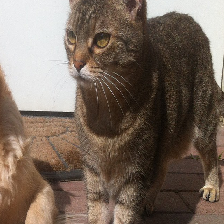

In [78]:
def best_image_for_label(l, label):
    return crop_images[max(l[label], key=lambda t:t[1])[0]]

best_image_for_label(crop_scores, 'Egyptian_cat')

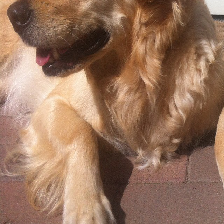

In [79]:
best_image_for_label(crop_scores, 'golden_retriever')

In [81]:
def create_top_model(base_model):
    inputs = Input(shape=(7, 7, 512), name='input')
    flatten = Flatten(name='flatten')(inputs)
    fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096, activation='relu', name='fc2')(fc1)
    predictions = Dense(1000, activation='softmax', name='predictions')(fc2)
    model = Model(inputs, predictions, name='top_model')
    for layer in model.layers:
        if layer.name != 'input':
            print(layer.name)
            layer.set_weights(base_model.get_layer(layer.name).get_weights())
    return model

top_model = create_top_model(base_model)
top_model.summary()

flatten
fc1
fc2
predictions
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________


In [82]:
bottom_model = vgg16.VGG16(weights='imagenet', include_top=False)
bottom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [84]:
p0 = base_model.predict(vgg16.preprocess_input(crops[:1]))
vgg16.decode_predictions(p0, top=1)

[[('n02099601', 'golden_retriever', 0.43540722)]]

In [93]:
b0 = bottom_model.predict(vgg16.preprocess_input(crops[:1]))
t0 = top_model.predict(b0[:, ::-1, :, :])
vgg16.decode_predictions(t0, top=1)

[[('n02099849', 'Chesapeake_Bay_retriever', 0.9809291)]]

In [110]:
f = K.function([base_model.input], [base_model.get_layer('block5_pool').output])
b1 = f([vgg16.preprocess_input(crops[:1])])[0]
t1 = top_model.predict(b1)
vgg16.decode_predictions(t1, top=1)

[[('n03590841', "jack-o'-lantern", 0.9953075)]]

In [60]:
img2 = image.load_img('data/cat_dog.jpg', target_size=(448, 448))
vector = np.expand_dims(image.img_to_array(img2), axis=0)
bottom_out = bottom_model.predict(vector)
bottom_out.shape

(1, 14, 14, 512)

In [59]:
vector = np.expand_dims(image.img_to_array(crop_images[0]), axis=0)
bottom_out_0 = bottom_model.predict(vector)
crop_pred_0 = model.predict(bottom_out_0)
vgg16.decode_predictions(crop_pred, top=1)

[[('n02095889', 'Sealyham_terrier', 0.2744007)]]

In [51]:
vec_crops = []
for x in range(7):
    for y in range(7):
        vec_crops.append(bottom_out[0, x: x + 7, y: y + 7, :])
vec_crops = np.asarray(vec_crops)
vec_crops.shape

(64, 7, 7, 512)

In [71]:
top_model.predict(bottom_out_0)dd

array([[3.55770657e-09, 3.93462294e-08, 4.14659773e-08, 1.31787402e-07,
        4.92801405e-07, 6.54871826e-07, 6.63671983e-07, 1.70062222e-07,
        2.00530326e-06, 1.73880736e-07, 7.68192709e-09, 3.70560684e-08,
        4.41928663e-08, 4.97032531e-08, 2.79507741e-08, 1.15795684e-08,
        4.01570226e-08, 2.85326905e-07, 6.33970876e-09, 1.25015703e-07,
        1.96647783e-08, 2.79533872e-08, 3.97802751e-08, 1.07297149e-06,
        1.48203199e-07, 1.60281632e-09, 2.75763767e-09, 2.29482522e-09,
        1.82261062e-09, 1.21744577e-07, 8.83696727e-10, 2.56919530e-09,
        8.39064374e-10, 2.28391404e-08, 1.65522955e-08, 1.10900467e-09,
        8.59278870e-09, 1.39666068e-09, 6.35959552e-09, 1.82324769e-08,
        8.83478002e-09, 2.29450570e-09, 2.59700217e-09, 1.48791841e-08,
        1.34286338e-09, 9.11275855e-09, 2.58485144e-08, 1.24684918e-09,
        9.77192514e-08, 7.68445862e-10, 1.56404631e-08, 5.11227931e-08,
        4.14684820e-09, 8.60933713e-10, 1.16761489e-09, 9.936617

In [75]:
top_model.predict(bottom_out[:1, :7, :7, :])

array([[2.22708785e-08, 1.68690704e-07, 8.51849791e-08, 5.95313168e-07,
        1.06925245e-06, 1.88444096e-06, 2.54886345e-06, 4.24182275e-07,
        1.53306712e-06, 1.11981819e-06, 6.32089083e-08, 4.09222594e-07,
        3.54872071e-07, 4.23640103e-07, 2.34984867e-07, 5.08857774e-08,
        4.22044820e-07, 2.53144572e-06, 8.17494268e-08, 9.43111900e-07,
        7.51880975e-08, 9.73369083e-08, 6.73365648e-08, 7.38291737e-06,
        6.81458005e-07, 4.70109178e-08, 7.29347391e-08, 5.39978835e-08,
        7.37443031e-08, 1.27916155e-06, 1.42122598e-08, 6.59652954e-08,
        2.93867970e-08, 1.51178327e-07, 1.64582119e-07, 1.03745563e-08,
        6.06434654e-08, 2.21301697e-08, 1.19852459e-07, 1.78898077e-07,
        3.17008670e-07, 4.91939183e-08, 4.84551173e-08, 1.19785270e-07,
        3.68372355e-08, 2.19206157e-07, 5.23055405e-07, 5.19387164e-08,
        5.37157348e-07, 9.91150628e-09, 1.15691691e-07, 1.10268154e-07,
        7.14838109e-08, 1.47730024e-08, 1.72891550e-08, 1.685315

In [43]:
crop_pred = model.predict(vec_crops)
l = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(crop_pred, top=1)):
    print(label)
    _, label, weight = pred[0]
    l[label].append((idx, weight))
l.keys()

Brittany_spaniel
Labrador_retriever
Labrador_retriever
feather_boa
feather_boa
feather_boa
tabby
tabby
tabby
Labrador_retriever
Labrador_retriever
feather_boa
feather_boa
feather_boa
lynx
tabby
Egyptian_cat
Labrador_retriever
Labrador_retriever
feather_boa
feather_boa
lynx
lynx
Egyptian_cat
Egyptian_cat
Labrador_retriever
Labrador_retriever
Labrador_retriever
lynx
lynx
lynx
Egyptian_cat
Egyptian_cat
Labrador_retriever
Labrador_retriever
Labrador_retriever
toilet_tissue
lynx
lynx
lynx
Egyptian_cat
golden_retriever
Labrador_retriever
Labrador_retriever
Brittany_spaniel
Brittany_spaniel
lynx
Egyptian_cat
Egyptian_cat
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
borzoi
borzoi
Eskimo_dog
Siberian_husky
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel
Brittany_spaniel


dict_keys(['Brittany_spaniel', 'Egyptian_cat', 'Eskimo_dog', 'borzoi', 'Labrador_retriever', 'feather_boa', 'Siberian_husky', 'golden_retriever', 'tabby', 'lynx', 'toilet_tissue'])

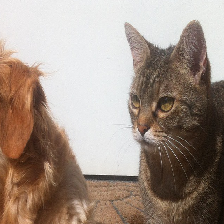

In [42]:
best_image_for_label('Labrador_retriever')

In [10]:
import sys
sys.path.append('../../../checkout/keras-frcnn')
import keras_frcnn, keras_frcnn.roi_helpers

import pickle
c = pickle.load(open('data/config.pickle', 'rb'))
c

In [34]:
import keras_frcnn.resnet as nn

num_features = 1024

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(c.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(c.anchor_box_scales) * len(c.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, c.num_rois, nb_classes=len(c.class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)


In [35]:
model_rpn.load_weights('data/model_frcnn.hdf5', by_name=True)
model_classifier.load_weights('data/model_frcnn.hdf5', by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [36]:
img = cv2.imread('data/cat_dog.jpg')

X, ratio = format_img(img, c)

if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))

y1, y2, f = model_rpn.predict(X)
r = keras_frcnn.roi_helpers.rpn_to_roi(y1, y2, c, K.image_dim_ordering(), overlap_thresh=0.7)
roi_count = R.shape[0] // c.num_rois
r2 = np.zeros((roi_count * c.num_rois, r.shape[1]))
r2 = r[:r2.shape[0],:r2.shape[1]]
r2 = np.reshape(r2, (roi_count, c.num_rois, r.shape[1]))


In [45]:
idx_to_class = {v: k for k, v in c.class_mapping.items()}
bboxes = []

C = c
for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//C.num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded

		[P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < 0.8 or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue

			cls_name = idx_to_class[np.argmax(P_cls[0, ii, :])]

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes.append((
                cls_name, np.max(P_cls[0, ii, :]), C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)
                                ))
del C
                           
bboxes =  list(sorted(bboxes, key=lambda t:t[1], reverse=True))
print(bboxes[:5])

[('cat', 0.99997997, 432, 80, 1088, 512), ('cat', 0.99997914, 448, 32, 1216, 544), ('dog', 0.99997544, 0, 128, 416, 576), ('cat', 0.99995291, 464, 64, 1200, 416), ('cat', 0.99994922, 400, 32, 1024, 528)]


In [83]:
r = keras_frcnn.roi_helpers.rpn_to_roi(Y1, Y2, c, K.image_dim_ordering(), overlap_thresh=0.7)
roi_count = R.shape[0] // c.num_rois
r2 = np.zeros((roi_count * c.num_rois, r.shape[1]))
r2 = r[:r2.shape[0],:r2.shape[1]]
r2 = np.reshape(r2, (roi_count, c.num_rois, r.shape[1]))
p_cls = []
p_regr = []
for i in range(r2.shape[0]):
    pred = model_classifier_only.predict([F, r2[i: i + 1]])
    p_cls.append(pred[0][0])
    p_regr.append(pred[1][0])
p_cls = np.asarray(p_cls)
p_regr = np.asarray(p_regr)
p_cls.shape, r2.shape, p_regr.shape

((9, 32, 21), (9, 32, 4), (9, 32, 80))

In [103]:
boxes = []
w, h, _ = r2.shape
for x in range(w):
    for y in range(h):
        cls_idx = np.argmax(p_cls[x][y])
        if cls_idx == len(idx_to_class) - 1:
            continue
        reg = p_regr[x, y, 4 * cls_idx:4 * (cls_idx + 1)]
        params = list(r2[x][y])
        params += list(reg / c.classifier_regr_std)
        box = keras_frcnn.roi_helpers.apply_regr(*params)
        box = list(map(lambda i: i * c.rpn_stride, box))
        boxes.append((idx_to_class[cls_idx], p_cls[x][y][cls_idx], box))


In [104]:
boxes2 = list(sorted(boxes, key=lambda t:t[1], reverse=True))
boxes2[:5]

[('cat', 0.99997997, [464, 64, 592, 448]),
 ('cat', 0.99997914, [432, 80, 736, 432]),
 ('dog', 0.99997544, [16, 112, 496, 448]),
 ('cat', 0.99995291, [416, 64, 736, 432]),
 ('cat', 0.99994922, [464, 80, 528, 432])]

In [137]:
new_config = pickle.load(open('data/config.pickle', 'rb'))
new_nb_classes = len(new_config.class_mapping)
out = model_classifier_only.layers[-3].output
new_out_class = TimeDistributed(Dense(new_nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(new_nb_classes))(out)
new_out_regr = TimeDistributed(Dense(4 * (new_nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(new_nb_classes))(out)
new_classifer =  [new_out_class, new_out_regr]


In [147]:
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))
shared_layers = nn.nn_base(img_input, trainable=True)

num_anchors = len(c.anchor_box_scales) * len(c.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(shared_layers, roi_input, c.num_rois, len(c.class_mapping), trainable=True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

model_rpn.load_weights('data/model_frcnn.hdf5', by_name=True)
model_classifier.load_weights('data/model_frcnn.hdf5', by_name=True)

In [148]:
new_config = pickle.load(open('data/config.pickle', 'rb'))
new_nb_classes = len(new_config.class_mapping)
out = model_classifier_only.layers[-3].output
new_out_class = TimeDistributed(Dense(new_nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(new_nb_classes))(out)
new_out_regr = TimeDistributed(Dense(4 * (new_nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(new_nb_classes))(out)
new_classifer =  [new_out_class, new_out_regr]

In [153]:
new_model_classifier = Model([img_input, roi_input], classifier)
new_model_rpn = Model(img_input, rpn[:2])

new_model_all = Model([img_input, roi_input], rpn[:2] + classifier)
new_model_all.save_weights('data/model_frcnn_new.hdf5')